In [1]:
import os
import json
import pandas as pd
import numpy as np
import xarray as xr

In [2]:
# WIDGETS
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

In [3]:
# plot
import matplotlib.pyplot as plt
import bg_mpl_stylesheet
from bg_mpl_stylesheet.bg_mpl_stylesheet import bg_mpl_style
plt.style.use(bg_mpl_style)
plt.ion()

In [4]:
def get_x_fitting_range(x, y, xrange: list):
    # x bound
    if xrange[0] == "min":
        xmin = float(x.min())
    else:
        xmin = float(xrange[0])
    if xrange[1] == "max":
        xmax = float(x.max())
    else:
        xmax = float(xrange[1])
    assert all([isinstance(xmin, float), isinstance(xmax, float)])
    
    bool_range = np.logical_and((x <= xmax), (x >= xmin))
    _x = x[bool_range]
    _y = list()
    for i, yi in enumerate(y):
        yi = yi[bool_range]
        _y.append(yi)
    return _x, np.array(_y)

def xy_dim_labels(xy_lable: str):
    dim_y = xy_lable[0]
    dim_x = xy_lable[1]
    if dim_y == 'i':
        dim_y = 'I (a.u.)'
    elif dim_y == 's':
        dim_y = 'S ($\mathrm{\AA^{-1}})$'
    elif dim_y == 'f':
        dim_y = 'F ($\mathrm{\AA^{-1}})$'
    elif dim_y == 'g':
        dim_y = 'G ($\mathrm{\AA^{-2}})$'
    if dim_x == 'q':
        dim_x = 'Q ($\mathrm{\AA^{-1}})$'
    elif dim_x == 'r':
        dim_x = 'r ($\mathrm{\AA})$'
    return dim_x, dim_y

def dump_da_json(da, path):
    da_dict = da.to_dict()
    with open(path, '+w') as f:
        json.dump(da_dict, f, sort_keys=False, indent=2)

In [5]:
def _setup_fig():
    if plt.fignum_exists(1):
        plt.clf()
    fig, ax = plt.subplots(num='plot')
    return fig, ax

def _setup_files(files):
    if isinstance(files, str):
        files = [files]
    return files

def _collect_data(files, xmin, xmax):
    # collect data 
    ys = list()
    for fname in files: 
        dat = np.loadtxt(fname).T
        x = dat[0]
        y = dat[1:]
        x, y = get_x_fitting_range(x, y, [xmin, xmax])
        ys.append(y)
    return x, ys

def _collect_feature_data(files):
    ys = list()
    for fname in files: 
        dat = np.loadtxt(fname).T
        if XLABELS:
            x = XLABELS
        else:
            x = dat[0]
        y = dat[1]
        ys.append(y)
    return x, ys

def _sum_to_1(arr: np.ndarray , axis:int = 0):
    norm = 1/arr.sum(axis=axis)
    arr = norm*arr
    return arr

def split_and_squeeze(arr):
    arr = np.split((arr), len(arr))
    arr = list(a.squeeze() for a in arr)
    return arr

def get_rw(y1, y2):
    """ y1 = data ; y2 = calc """
    return float(np.sqrt((((y1 - y2) ** 2).sum()) / ((y2 ** 2).sum()))).__round__(3)

In [6]:
def _plot(fig, ax, x,y, yshift, data_type, fname, add_legends):
    # assign
    y, diff, fit = y[0:3]
    
    # plot
    ax.set_title(f"{fname}")
    dim_x, dim_y = xy_dim_labels(data_type)
    ax.set_xlabel(dim_x)
    ax.set_ylabel(dim_y)
    ax.set_xlim(x.min(),x.max())

    ## data
    ax.plot(x, np.zeros(len(x)), alpha=0.5, c='C4')
    ax.plot(x, y, alpha=0.4, marker='o', markeredgewidth=1, fillstyle='none', markersize=7,  c="C0", label='data')

    ## fit
    ax.plot(x, fit, alpha=0.8, c="C1", label='fit')

    ## diff
    ax.plot(x, np.zeros(len(x)) + (yshift), alpha=0.7, c='C4')
    ax.plot(x, diff + (yshift), alpha=0.8, c="C2", label='diff')
    
    if add_legends:
        ax.legend()
    fig.canvas.flush_events()

def _plot_compare(fig, ax, x, ys, yshift, data_type, files, draw_type, add_diff, diff_shift, mult_scaling, same_color, add_legends):
    # assign
    s = 0
    if yshift==0:
        ax.plot(x, np.zeros(len(x)), alpha=0.5, c='C4')
    dim_x, dim_y = xy_dim_labels(data_type)
    ax.set_xlabel(dim_x)
    ax.set_ylabel(dim_y)
    ax.set_xlim(x.min(),x.max())
    ax.set_title(f'{draw_type}')
    diff = None
    for i, (y, fname) in enumerate(zip(ys, files)):
        if draw_type == 'data': 
            y = y[0]
        if draw_type == 'fit': 
            y = y[2]
        if draw_type == 'diff': 
            y = y[1]
        if i == 0:
            diff = y 
        if i == 1:
            y = y * mult_scaling
            diff -= y
        if same_color:
            c = 'C0'
        else:
            c = f'C{i}'
        ax.plot(x, y  + s, alpha=0.8, label=fname, c=c)
        s += yshift 
    if len(files) == 2 and add_diff:
#         rw = get_rw(ys[0], ys[1])
#         rw = np.abs(np.sum(diff)).__round__(3)
        ax.plot(x, np.zeros(len(x)) + diff_shift, alpha=0.5, c='C4')
        ax.plot(x, diff + diff_shift, alpha=0.8, label=f'diff')
    
    if add_legends:
        ax.legend()
        
    fig.canvas.flush_events()

    
def _scatter_features(fig, ax, x, ys, files, marker1, marker2, linewidth, add_legends):
    # assign
    ax.set_xlabel(DIMX)
    ax.set_ylabel(DIMY)
    ax.set_title(f'{TITLE}')
    for i, (y, fname) in enumerate(zip(ys, files)):
        if len(ys) == 2:
            if i == 0:
                ax.plot(x, y, '--', alpha=0.8, lw = linewidth, marker = marker1, label=fname)
            elif i == 1:
                ax.plot(x, y, '--', alpha=0.8,  lw = linewidth, marker = marker2, label=fname)
        else:
            ax.plot(x, y, '--', alpha=0.8,  lw = linewidth, marker = MARKERS[i], label=fname)
    
    if add_legends:
        ax.legend()
    fig.canvas.flush_events()


In [7]:
def draw(fname, data_type:str, xmin:float, xmax:float, yshift:float, add_legends:bool):
    files = _setup_files(fname)
    fig, ax = _setup_fig()
    x, ys = _collect_data(files, xmin, xmax)
    y = ys[0]
    _plot(fig, ax, x,y, yshift, data_type, fname, add_legends)
    
def draw_compare_data(compare_all: bool, file1:str, file2:str, draw_type: str, add_diff:bool,
                      data_type:str, xmin:float, xmax:float, yshift:float, diff_shift:float, mult_scaling:float, 
                      same_color: bool, add_legends: bool):
    files = FILES
    if not compare_all:
        files = [file1] + [file2]
    fig, ax = _setup_fig()
    x, ys = _collect_data(files, xmin, xmax)
    _plot_compare(fig, ax, x, ys, yshift, data_type, files, draw_type, add_diff, diff_shift, mult_scaling, same_color, add_legends)   
    
def draw_features(compare_all: bool, normalize: bool,
                  special_pre_norm:bool, special_post_norm:bool, 
                  file1:str, file2:str, marker1, marker2, linewidth, add_legends):
    files = FILES
    if not compare_all:
        files = [file1] + [file2]        
    fig, ax = _setup_fig()
    x, ys = _collect_feature_data(files)
    ys = np.array(ys)
    if special_pre_norm:
        ys = special_f1(ys)
    if normalize:
        ys = _sum_to_1(ys, axis=0)
    if special_post_norm:
        ys = special_f2(ys)
    ys = split_and_squeeze(ys)
    _scatter_features(fig, ax, x, ys, files, marker1, marker2, linewidth, add_legends) 

In [8]:
arr = np.array([[1,2,3], [3,2,1]])
for a in arr:
    print(a)

print(len(arr))
print(arr)
_sum_to_1(arr)

[1 2 3]
[3 2 1]
2
[[1 2 3]
 [3 2 1]]


array([[0.25, 0.5 , 0.75],
       [0.75, 0.5 , 0.25]])

In [9]:
def set_dirpath(dirpath):
    os.chdir(os.path.abspath(dirpath))

In [10]:
path = widgets.FileUpload(
    accept='',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=True)
w_path = widgets.HBox([widgets.Label("files :"), path])

In [16]:
dirpath = list(l for l in os.listdir() if os.path.isdir(os.path.abspath(l)))
interact_manual(set_dirpath, dirpath=dirpath+['..'])
!pwd
!ls

interactive(children=(Dropdown(description='dirpath', options=('..',), value='..'), Button(description='Run In…

/home/yr2369/dev/pdfgui_plotter/myplotter/sim_pair_clustering/fitting results
 100   55   65	 75   85   95		    rw	   Zr--X
 50    60   70	 80   90  'pair fraction'   X--X   Zr--Zr


In [12]:
display(w_path)

In [17]:
# global 
FILES = list(path.value.keys())
print(os.getcwd())
print(FILES)

/home/yr2369/dev/pdfgui_plotter/myplotter/sim_pair_clustering/fitting results
['Zr--X', 'Zr--Zr', 'X--X']


In [18]:
# get x range
dat = np.loadtxt(FILES[0]).T
x = dat[0]

In [19]:
interactive_draw = interactive(draw, 
                               fname = FILES, 
                               data_type = ['gr', 'fq', 'sq', 'iq'], 
                               xmin=(x.min()-x.min()/10, x.max()), 
                               xmax = (x.min(),x.max()+x.max()/10), 
                               yshift=(-5,5,0.1),
                               add_legends = True)

In [20]:
%matplotlib qt

In [21]:
%matplotlib inline

interactive(children=(Dropdown(description='fname', options=('Zr--X', 'Zr--Zr', 'X--X'), value='Zr--X'), Dropd…

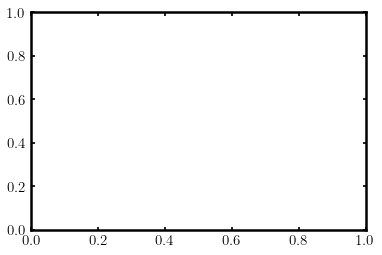

In [22]:
interactive_draw

In [23]:
interactive_draw_compare_data = interactive(draw_compare_data, 
                                            compare_all = False,
                                            file1 = FILES,
                                            file2 = FILES,
                                            draw_type = ['data', 'fit', 'diff'],
                                            mult_scaling = (0, 2, 0.01),
                                            add_diff = False,
                                            data_type = ['gr', 'fq', 'sq', 'iq'], 
                                            xmin=(x.min()-x.min()/10, x.max()), 
                                            xmax = (x.min(),x.max()+x.max()/10), 
                                            yshift=(-5,5,0.1), 
                                            diff_shift = (-5,5,0.1),
                                           same_color = False, 
                                           add_legends = False)

interactive(children=(Checkbox(value=False, description='compare_all'), Dropdown(description='file1', options=…

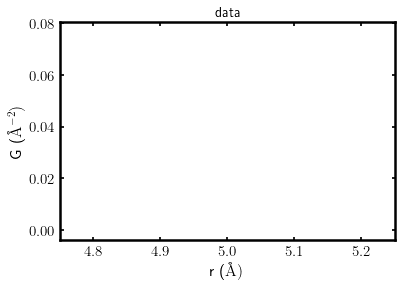

In [24]:
interactive_draw_compare_data

In [25]:
XLABELS = np.arange(50,105,5).tolist()
# XLABELS = None
DIMX = 'y index'
DIMY = 'pair \%'
TITLE = ''
# MARKERS = ['o','s', 'p', 'h', '8',  '.', 'v','<', 'X']
MARKERS = ['o', 'o', 'o']

In [26]:
interactive_draw_features = interactive(draw_features, 
                                        compare_all = False,
                                        normalize = False,  
                                        special_pre_norm= False, 
                                        special_post_norm = False,
                                        special = False,
                                        file1 = FILES,
                                        file2 = FILES,
                                        marker1 = MARKERS,
                                        marker2 = MARKERS,
                                        linewidth = [1,2,3,4,5,0],
                                        add_legends = False,
                                        )

In [27]:
def special_f1(ys):
    ys = split_and_squeeze(ys)
    X_Zr = ys.pop(-1)
    ys = np.array(ys)
    ys = ys + X_Zr/2
    return ys

def special_f2(ys):
    return ys*100

interactive(children=(Checkbox(value=True, description='compare_all'), Checkbox(value=True, description='norma…

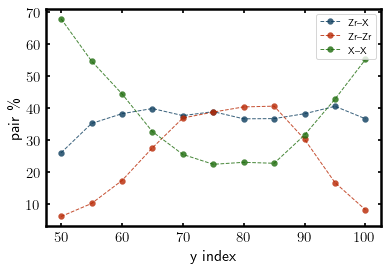

In [31]:
interactive_draw_features

In [52]:
# serialize to xr json dict for compatibility with 
xmin, xmax = (2,4)
x, ys = _collect_data(FILES, xmin, xmax)
for y, f in zip(ys, FILES):
    data = y[0]
    diff = y[1]
    fit = y[2]
    da = xr.DataArray(np.array([x,fit]), dims = ('r', 'g'), attrs={'config':{'xmin':xmin, 'xmax':xmax, 'path':os.path.abspath(f)}})
    path = "xrda_00-" + f.replace('.', '') + ".gr"
    path = os.path.join('for_minipipes', path)
    dump_da_json(da, path)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [162]:
# after generating a fit serias with minipipes --> visuallize results
# qoi_results_path = '/home/yr2369/dev/pdfgui_plotter/myplotter/sim_pair_clustering/Ni-Zr/for_minipipes/fits/QOImap_TwoGaussianPoly1.qmap'
# qoi_results_path = '/home/yr2369/dev/pdfgui_plotter/myplotter/sim_pair_clustering/Ni-Ni/for_minipipes/fits/QOImap_TwoGaussianPoly1.qmap'
qoi_results_path = '/home/yr2369/dev/pdfgui_plotter/myplotter/sim_pair_clustering/Zr-Zr/for_minipipes/fits/QOImap_TwoGaussianPoly1.qmap'

fits = json.load(open(qoi_results_path, 'r'))

In [320]:
qois = fits['prerun']['optimization_parameters']
qois

['amp_1', 'cen_1', 'wid_1', 'amp_2', 'cen_2', 'wid_2', 'x0', 'x1']

In [321]:
# build result dict 
x = list()
y = dict((qoi,list()) for qoi in qois)
y.update({'Rw':list()})
for k, v in fits['results'].items():
    x.append(v['index'][1]*0.1)
    qoi_vals = v['popt']
    for qoi_name, qoi_val in zip(qois, qoi_vals):
        y[qoi_name].append(qoi_val)
    y['Rw'].append(v['Rw'])
    
# mk qoi lists to np.array obj
for k, v in y.items():
    y[k] = np.array(v) 

In [322]:
# set parameters namespace based on key
add_Rw = False
for qoi in qois:
    exec(f'{qoi} = y["{qoi}"]')
if add_Rw:
    Rw = y["Rw"]

Zr-Zr


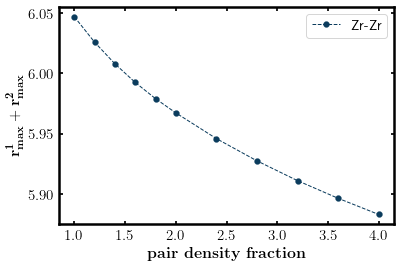

In [326]:
# plot eval_string
# plt.clf()
# eval_string = "cen_2-cen_2.min(), cen_1-cen_1.min()"
eval_string = "cen_1+cen_2"
parsed_eval_string = eval_string.split(',')
for eval_str in parsed_eval_string:
    eval_str = eval_str.strip()
#     eval_str_text = eval_str.replace('_', '\_')
    eval_str_text = qoi_results_path.split('/')[7]
    print(eval_str_text)
    _y = eval(eval_str)
    plt.plot(x,_y, '--o',lw=1,label = eval_str_text)
plt.xlabel('\\bf{pair density fraction}')
plt.ylabel('$\\mathrm{\\bf{r^{1}_{max}+r^{2}_{max}}}$')
# plt.ylim([5.95, 6.11])
plt.legend(fontsize=14)